# Chapter 1: Introduction to Bayesian Optimization

In this chapter, we introduce Bayesian Optimization (BayesOpt) as a powerful technique for optimizing expensive black-box functions. This method is particularly useful in settings where each function evaluation (such as training a machine learning model) is costly in terms of time, money, or computational resources.


## 1.1 The Need for Bayesian Optimization

### Why Bayesian Optimization?
- **Unknown Internal Mechanics:** The underlying structure of the function is unknown (a black-box).
- **Costly Evaluations:** Each function evaluation can be very expensive.
- **Limited Resources:** We only have a limited number of evaluations available.

### Example: Hyperparameter Tuning
Consider hyperparameter tuning in machine learning. For instance, when deciding the number of layers in a neural network:
- **Different architectures lead to different accuracies.**
- **Training a new model is time-consuming and computationally expensive.**

Bayesian Optimization helps us efficiently find the optimal configuration with minimal trials.


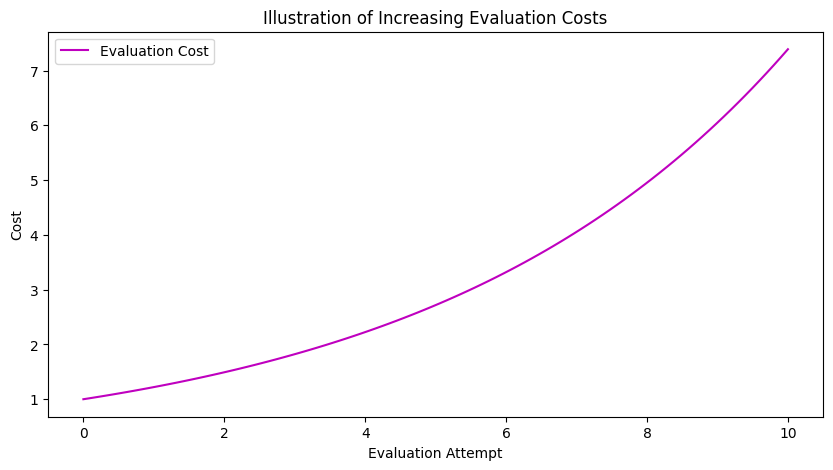

In [2]:
# Visualization: Plotting a simple illustration of evaluation costs
import matplotlib.pyplot as plt
import numpy as np

# Create a simple plot to illustrate the idea of "cost" in evaluations.
x = np.linspace(0, 10, 100)
cost = np.exp(x/5)  # An arbitrary function to simulate increasing cost

plt.figure(figsize=(10, 5))
plt.plot(x, cost, 'm-', label='Evaluation Cost')
plt.title("Illustration of Increasing Evaluation Costs")
plt.xlabel("Evaluation Attempt")
plt.ylabel("Cost")
plt.legend()
plt.show()

## 1.2 Introduction to Bayesian Optimization

### What is Bayesian Optimization?
Bayesian Optimization is an optimization strategy that builds a probabilistic model—typically a Gaussian Process (GP)—to model the unknown function. It then uses an acquisition function to decide where to sample next.

### Key Components:
- **Gaussian Process (GP):**  
  - A GP is a probabilistic model that provides predictions along with uncertainty estimates.
  - It offers a confidence interval for each prediction, which is crucial for balancing between exploring new areas and exploiting known high-performing regions.

- **Acquisition Function (Policy):**  
  - The acquisition function assigns a score to potential points.
  - It balances exploration (testing uncertain regions) and exploitation (focusing on promising areas).

### The Bayesian Optimization Loop:
1. **Train the GP model** on the observed data.
2. **Evaluate the acquisition function** to select the next point.
3. **Update the GP model** with the new observation.
4. **Repeat** until an optimum is found.


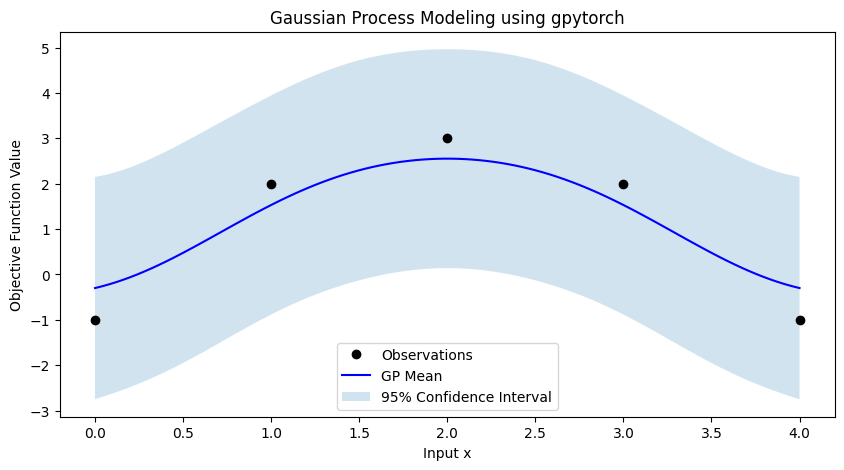

In [6]:
# Import necessary libraries from gpytorch and torch.
import torch
import gpytorch

# Define the Exact GP Model using gpytorch.
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Use a constant mean function and RBF kernel wrapped in a ScaleKernel.
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define a simple quadratic objective function with maximum at x=2.
def objective_function(x):
    return -((x - 2)**2) + 3

# Generate initial training data.
train_x = torch.linspace(0, 4, 5)
train_y = objective_function(train_x)

# Reshape train_x for gpytorch (n x 1).
train_x = train_x.unsqueeze(-1)

# Initialize the likelihood and model.
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Set the model in training mode.
model.train()
likelihood.train()

# Use the Adam optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Switch to evaluation mode.
model.eval()
likelihood.eval()

# Create a grid for predictions.
x_grid = torch.linspace(0, 4, 100).unsqueeze(-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_grid))

# Extract mean and confidence intervals.
mean = observed_pred.mean.numpy()
lower, upper = observed_pred.confidence_region()
lower = lower.numpy()
upper = upper.numpy()

# Plot the GP's mean prediction and confidence intervals.
plt.figure(figsize=(10, 5))
plt.plot(train_x.numpy(), train_y.numpy(), 'ko', label='Observations')
plt.plot(x_grid.numpy(), mean, 'b-', label='GP Mean')
plt.fill_between(x_grid.squeeze().numpy(), lower, upper, alpha=0.2, label='95% Confidence Interval')
plt.title("Gaussian Process Modeling using gpytorch")
plt.xlabel("Input x")
plt.ylabel("Objective Function Value")
plt.legend()
plt.show()


## 1.3 Bayesian Optimization in Action

Bayesian Optimization is often compared to other search strategies:
- **Random Search:** Randomly selects points, which may result in wasted evaluations.
- **Grid Search:** Tests points on a fixed grid, inefficiently covering the input space.
- **Bayesian Optimization:** Selects points based on a strategic trade-off between exploration and exploitation, thereby focusing on high-value and high-uncertainty areas.

### Demonstration Example:
Imagine starting with a few random points. Bayesian Optimization will quickly start focusing on regions that appear promising, thus efficiently converging on the global optimum.


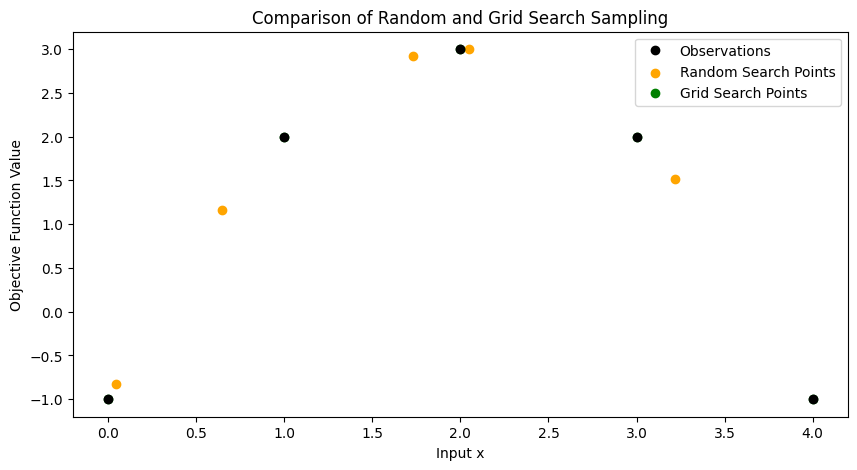

In [7]:
# Visualization: Compare random and grid search sampling with our objective function.

import random

# Generate random search points.
random_points = np.array([random.uniform(0, 4) for _ in range(5)])

# Generate grid search points.
grid_points = np.linspace(0, 4, 5)

plt.figure(figsize=(10, 5))
plt.plot(train_x.numpy(), train_y.numpy(), 'ko', label='Observations')
plt.scatter(random_points, objective_function(torch.tensor(random_points).unsqueeze(-1)).numpy(),
            color='orange', label='Random Search Points')
plt.scatter(grid_points, objective_function(torch.tensor(grid_points).unsqueeze(-1)).numpy(),
            color='green', label='Grid Search Points')
plt.title("Comparison of Random and Grid Search Sampling")
plt.xlabel("Input x")
plt.ylabel("Objective Function Value")
plt.legend()
plt.show()


## 1.4 When to Use (or Not Use) Bayesian Optimization

### Use Bayesian Optimization When:
- Function evaluations are expensive.
- You have limited time or computational resources.
- The function’s structure is unknown.

### Avoid Bayesian Optimization When:
- Evaluations are cheap (an exhaustive search might suffice).
- Gradient information is available (gradient-based methods might be more efficient).
- Other optimization strategies (e.g., evolutionary algorithms) are better suited for the problem at hand.


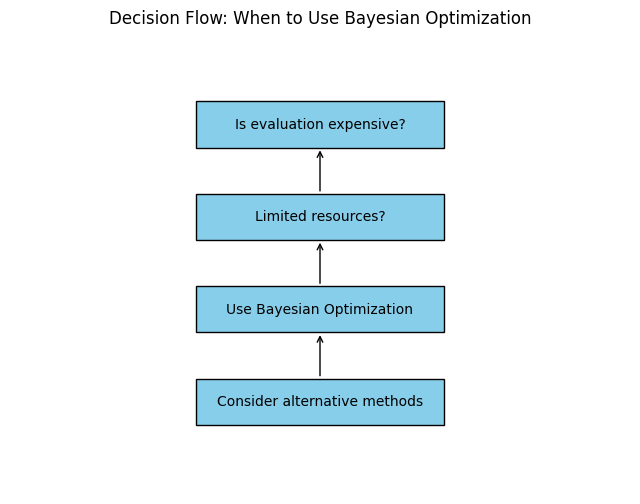

In [8]:
# Visualization: A simple decision flowchart for when to use Bayesian Optimization

import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Define decision boxes.
boxes = {
    "A": {"text": "Is evaluation expensive?", "pos": (5, 8)},
    "B": {"text": "Limited resources?", "pos": (5, 6)},
    "C": {"text": "Use Bayesian Optimization", "pos": (5, 4)},
    "D": {"text": "Consider alternative methods", "pos": (5, 2)}
}

# Draw boxes and add text.
for box in boxes.values():
    rect = patches.Rectangle((box["pos"][0]-2, box["pos"][1]-0.5), 4, 1,
                             fill=True, color='skyblue', ec='black')
    ax.add_patch(rect)
    ax.text(box["pos"][0], box["pos"][1], box["text"],
            ha="center", va="center", fontsize=10)

# Draw arrows between boxes.
ax.annotate("", xy=(5, 7.5), xytext=(5, 6.5), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(5, 5.5), xytext=(5, 4.5), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(5, 3.5), xytext=(5, 2.5), arrowprops=dict(arrowstyle="->"))

plt.title("Decision Flow: When to Use Bayesian Optimization")
plt.show()


## 1.5 What You Will Learn in This Series

In the tutorials that follow, you will learn:
- How to build and use Gaussian Processes with GPyTorch.
- How to implement Bayesian Optimization policies using BoTorch.
- How to optimize various black-box problems, including hyperparameter tuning.
- How to apply Bayesian Optimization in real-world scenarios like ML tuning and scientific discovery.


## Key Takeaways

- **Efficiency:** Bayesian Optimization finds the optimal solution with fewer expensive function evaluations.
- **Modeling:** It uses Gaussian Processes to predict function values and quantify uncertainty.
- **Strategic Search:** By combining predictions with an acquisition function, it strategically balances exploration and exploitation.
- **Broad Applicability:** It is widely used in fields such as machine learning, drug discovery, material science, and more.
